In [1]:
import numpy as np

from matplotlib import pyplot as plt, cm, colors

import torch
from torch import tensor, nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/schilln/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I borrow code and ideas from

- ["Understanding Generalization through Visuzalizations"](https://arxiv.org/abs/1906.03291) (Huang et al, 2019) in their repository [`wronnyhuang/gen-viz`](https://github.com/wronnyhuang/gen-viz)
- ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/abs/1712.09913) (Li et al, 2018) in their repository [`tomgoldstein/loss-landscape`](https://github.com/tomgoldstein/loss-landscape)

## Visualize data

In [2]:
### Adapted from `gen-viz`
def twospirals(n_points, noise=0.5, rng=None):
  """
    Returns the two spirals dataset.
  """
  if rng is None:
    rng = np.random.default_rng(42)

  n = np.sqrt(rng.uniform(size=(n_points, 1))) * 600 * (2*np.pi)/360
  d1x = -1.5*np.cos(n)*n + rng.uniform(size=(n_points, 1)) * noise
  d1y =  1.5*np.sin(n)*n + rng.uniform(size=(n_points, 1)) * noise
  return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

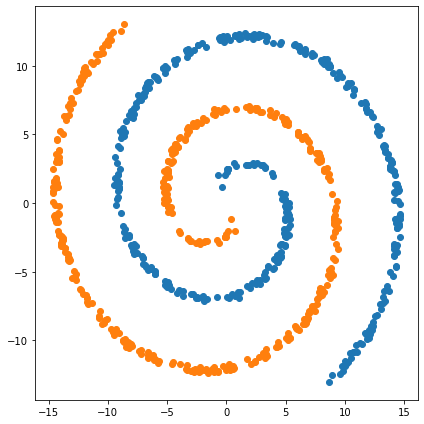

In [3]:
N = 400

X, Y = twospirals(N)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(*X[Y == 0].T)
ax.scatter(*X[Y == 1].T)

fig.tight_layout()
fig.show()

## Prep dataset and dataloaders

In [4]:
class Swissroll(Dataset):
  def __init__(self, X, Y):
    self.X, self.Y = X, Y
  
  def __len__(self): return len(self.Y)

  def __getitem__(self, idx): return self.X[idx], self.Y[idx]

In [5]:
X, Y = twospirals(N)
dataset = Swissroll(tensor(X, dtype=torch.float), tensor(Y, dtype=torch.int64))

test_size = 0.1
random_split_rng = torch.Generator()
train_rng = torch.Generator()

train_batch_size = 16
test_batch_size = 16

random_split_rng.manual_seed(42)
train_set, test_set = random_split(dataset, (1 - test_size, test_size), generator=random_split_rng)

train_loader = DataLoader(train_set, train_batch_size, shuffle=True, generator=train_rng)
train_loader.num_samples = len(train_set)
test_loader = DataLoader(test_set, test_batch_size, shuffle=False)
test_loader.num_samples = len(test_set)

## Define model

In [28]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(42)

    # This appears to be what Huang et al used
    num_hidden = (23, 16, 26, 32, 28, 31)

    num_hidden = (16, 16, 16, 16, 16, 16)

    relu = nn.ReLU()

    layers = [[nn.Linear(prev, post), relu] for prev, post in zip(num_hidden[:-1], num_hidden[1:])]
    layers = sum(layers, [])

    self.seq = nn.Sequential(
      nn.Linear(2, num_hidden[0]), # Input data is two-dimensional,
      relu,
      *layers,
      nn.Linear(num_hidden[-1], 2) # Two output classes
    )

    self.num_params = sum([p.numel() for p in self.parameters() if p.requires_grad])
    self.weights = None

  def forward(self, X):
    return self.seq(X)
  
  # Inspired by `gen-viz`
  def infer(self, X):
    return torch.argmax(self(X), axis=1)

  # Record the weights at a specific point in time as a reference
  def record_weights(self): self.weights = [p.data for p in self.parameters()]

  def reset_weights(self):
    if self.weights is not None:
      for p, w in zip(self.parameters(), self.weights):
        p.data = w
  
print(f"number of parameters: {Model().num_params}")

number of parameters: 1442


## Train and test loops

In [29]:
def train(model, opt, num_epochs, train_loader, print_every=10):
  obj = nn.CrossEntropyLoss()
  model.train()

  seeds = np.arange(num_epochs)

  # Mean loss per sample
  mean_train_losses = [None] * num_epochs
  accs = [None] * num_epochs

  for epoch in range(num_epochs):
    # Train
    train_rng.manual_seed(int(seeds[epoch]))

    epoch_loss = 0
    correct = 0
    for x, y in train_loader:
      x, y = x.to(device), y.to(device)
      opt.zero_grad()

      # Predict, get loss, backprop, step
      pred = model(x)

      loss = obj(pred, y)
      loss.backward()
      opt.step()

      epoch_loss += loss.item()
      correct += torch.sum(torch.argmax(pred, axis=1) == y).item()

    # Record
    mean_train_losses[epoch] = epoch_loss / train_loader.num_samples
    accs[epoch] = correct / train_loader.num_samples

    if epoch % print_every == 0:
      print(f"epoch: {epoch:>5} | mean loss: {mean_train_losses[epoch]:.3f} | accuracy: {accs[epoch]:.3f}")
    
  return tensor(mean_train_losses), tensor(accs)

def test(model, test_loader):
  obj = nn.CrossEntropyLoss()
  model.eval()

  loss = 0
  correct = 0
  for x, y in test_loader:
    x, y = x.to(device), y.to(device)

    pred = model(x)

    loss += obj(pred, y).item()
    correct += torch.sum(torch.argmax(pred, axis=1) == y).item()

  mean_loss = loss / len(test_set)
  acc = correct / len(test_set)

  return mean_loss, acc

In [30]:
num_epochs = 30
lr = 1e-2
model = Model().to(device)
opt = optim.Adam(model.parameters(), lr=lr)
obj = nn.CrossEntropyLoss()

mean_train_losses, train_accs = train(model, opt, num_epochs, train_loader, print_every=10)

mean_test_loss, test_acc = test(model, test_loader)

model.record_weights()

epoch:     0 | mean loss: 0.040 | accuracy: 0.631
epoch:    10 | mean loss: 0.002 | accuracy: 0.988
epoch:    20 | mean loss: 0.000 | accuracy: 0.999


## Plot decision boundary

dark points are test samples


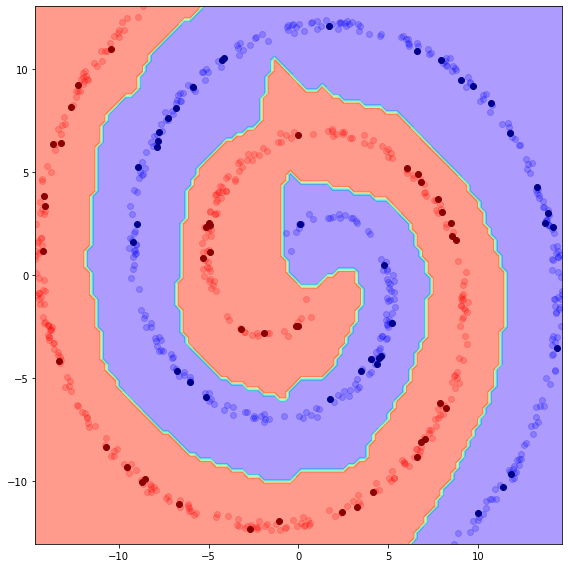

In [36]:
### Adapted from `gen-viz`

# Predict the classification on a grid of points
model.eval()

model.reset_weights()

xn = yn = 100
xls = np.linspace(X[:, 0].min(), X[:, 0].max(), xn)
yls = np.linspace(X[:, 1].min(), X[:, 1].max(), yn)

xx1, xx2 = np.meshgrid(xls, yls)

xstack = np.column_stack([xx1.ravel(), xx2.ravel()])
pred = model.infer(tensor(xstack, dtype=torch.float))
yy = np.reshape(pred, xx1.shape)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot decision boundary
ax.contourf(xx1, xx2, yy, alpha=0.5, cmap="rainbow")

# Plot train data
train_mask = train_set[:][1] == 1
alpha = 0.2
ax.scatter(*train_set[:][0][train_mask].T, color="red", alpha=alpha)
ax.scatter(*train_set[:][0][~train_mask].T, color="blue", alpha=alpha)

# Plot test data
test_mask = test_set[:][1] == 1
ax.scatter(*test_set[:][0][test_mask].T, color="darkred")
ax.scatter(*test_set[:][0][~test_mask].T, color="darkblue")

print("dark points are test samples")
fig.tight_layout()
fig.show()

## Define helper functions

- get cax to add colorbar
- get weight directions
- scale weight directions
- set model weights
- get loss on an entire dataset for current weights
- get loss on an entire dataset over region in weight space
- plot loss on train and test sets over region in weight space

In [39]:
def get_cax(fig, ax, pad, width):
  """Get cax for adding a colorbar."""
  cax = fig.add_axes((
    ax.get_position().x1 + pad,
    ax.get_position().y0,
    width,
    ax.get_position().height
  ))
  return cax

### Adapted from `loss-landscape`
def get_random_weights(weights, rng):
  """
    Produce a random direction that is a list of random Gaussian tensors
    with the same shape as the network's weights, so one direction entry per weight.
  """
  return [torch.randn(w.size(), generator=rng) for w in weights]

def get_2_random_dirs(weights, rng):
  return [get_random_weights(weights, rng) for _ in range(2)]

### Adapted from `loss-landscape`
def scale_dirs(weights, dirs):
  """
    Set bias directions to zero (`loss-landscape` does this in their example code).
    Scale directions to have norm equal to that of the corresponding layer's weights.
  """
  for dir_i in dirs:
    for d, w in zip(dir_i, weights):
      if d.dim() <= 1:
        # Ignore biases by setting their directions to zero.
        d.fill_(0)
      else:
        d.mul_(w.norm() / d.norm())

### Adapted from `loss-landscape`
def set_weights(model, dirs, steps):
  """
    Set the weights of the model a step in each direction, i.e.,
    (new_weights = original_weights + step * direction) where original_weights
    is the value set at a given point in time by calling model.record_weights().
  """
  changes = [d0 * steps[0] + d1 * steps[1] for (d0, d1) in zip(*dirs)]

  for (p, w, change) in zip(model.parameters(), model.weights, changes):
    p.data = w + change

def eval_set(model, loader):
  """Get the loss on entire dataset."""
  model.eval()
  
  loss = 0
  for x, y in loader:
    x, y = x.to(device), y.to(device)

    # Predict, get loss, backprop, step
    pred = model(x)

    loss += obj(pred, y)
  
  return loss.item() / loader.num_samples

def get_loss_surface(model, loader, dirs, xn=50, yn=50):
  n = xn * yn
  xls = np.linspace(-1, 1, xn)
  yls = np.linspace(-1, 1, yn)

  xsteps, ysteps = np.meshgrid(xls, yls)
  xis, yis = np.meshgrid(np.arange(xn), np.arange(yn))

  losses = np.full((yn, xn), np.inf)

  # Set the random seed of the loader even though shouldn't be necessary when using entire loader
  if loader.generator is not None:
    loader.generator.manual_seed(42)

  for i, (xstep, ystep, xi, yi) in enumerate(zip(*map(np.ravel, (xsteps, ysteps, xis, yis)))):
    if i % 500 == 0:
      print(f"{i:>5} / {n}")
    set_weights(model, dirs, (xstep, ystep))

    losses[yi, xi] = eval_set(model, loader)

  return xsteps, ysteps, losses

def plot_loss_surfaces(train_losses, test_losses, xsteps, ysteps):
  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  logtrainlosses, logtestlosses = np.log(train_losses), np.log(test_losses)

  cmap = cm.magma
  norm = colors.Normalize(min(logtrainlosses.min(), logtestlosses.min()),
                          max(logtrainlosses.max(), logtestlosses.max()))

  ax = axs[0]
  contour = ax.contourf(xsteps, ysteps, logtrainlosses, levels=50, norm=norm, cmap=cmap)
  ax.set_title("train")

  ax = axs[1]
  contour = ax.contourf(xsteps, ysteps, logtestlosses, levels=50, norm=norm, cmap=cmap)
  ax.set_title("test")

  [ax.set_aspect("equal") for ax in axs]

  fig.tight_layout()

  pad, width = 0.02, 0.05
  cax = get_cax(fig, axs[1], pad, width)

  fig.colorbar(contour, cax=cax)

  fig.show()

## Loss surface in weight-space

### with scaling of directions

In [44]:
rng = torch.Generator().manual_seed(42)
dirs = get_2_random_dirs(model.weights, rng)
scale_dirs(model.weights, dirs)

xsteps, ysteps, train_losses = get_loss_surface(model, train_loader, dirs)
xsteps, ysteps, test_losses = get_loss_surface(model, test_loader, dirs)

    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500
    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500


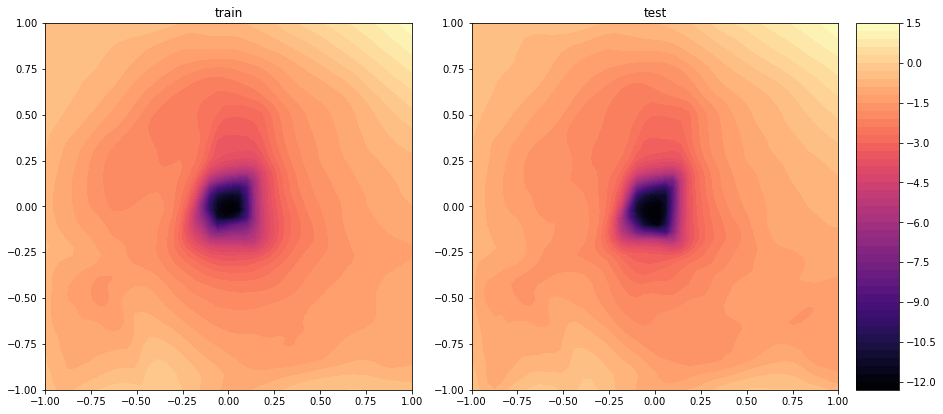

In [45]:
plot_loss_surfaces(train_losses, test_losses, xsteps, ysteps)

### without scaling of directions

In [37]:
rng = torch.Generator().manual_seed(42)
dirs = get_2_random_dirs(model.weights, rng)

xsteps, ysteps, train_losses = get_loss_surface(model, train_loader, dirs)
xsteps, ysteps, test_losses = get_loss_surface(model, test_loader, dirs)

    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500
    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500


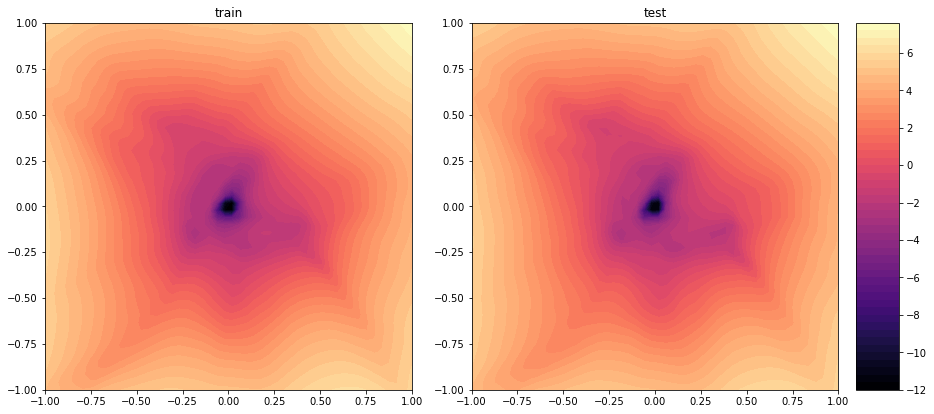

In [43]:
plot_loss_surfaces(train_losses, test_losses, xsteps, ysteps)